# Kaggle Microsoft Malware competition 2019(Currently Active):

### Link : https://www.kaggle.com/c/microsoft-malware-prediction

### Problem Overview: Microsoft is challenging the data science community to develop techniques to predict if a machine will soon be hit with malware. They have provided 82 feature columns, and 8.7 million rows based on which previous detection rates have been measured. The end goal is to come up with a model for predicting malware occurrences in the future.

### Rather than using the entire datset, we have used 1,00,000 randomly sampled rows, from training dataset to keep the session interactive, rather than using the whole dataset.

### Part1: RandomForestClassifier Approach For BaseLine Model

In [1]:
#Importing necessary libraries!
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics
# Plotly library
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 500)

In [2]:
# Using Fast_Ai 0.7, to install on your machine use command (pip install fastai==0.7.0) in terminal
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
#Very Important to describe dtypes, whenever dealing with large datasets
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [4]:
PATH = "datasets/"

In [5]:
!ls {PATH}

keep_cols.npy  train.csv


In [13]:
#Reading the dataset

In [6]:
#Divide the features in numeric and categories
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics] #Will fetch columns, whose dtype is numeric
categorical_columns = [c for c,v in dtypes.items() if v not in numerics] #Will fetch columns , whose dtype is non-numeric

In [7]:
retained_columns = numerical_columns + categorical_columns

In [8]:
df_raw = pd.read_csv(f'{PATH}train.csv',  usecols = retained_columns,
                    dtype = dtypes)

In [9]:
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        display(df)

In [10]:
df_raw.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,844d853facbcb13bfa199cd1c324e7d7,mse,1.1.15200.1,4.10.209.0,1.275.1141.0,0,7.0,0,NaN,29199.0,1.0,1.0,0,160,48464.0,NaN,204.0,-86,windows7,x64,6.1.1.0,7601,256,windows7,7601.24231.amd64fre.win7sp1_ldr.180810-0600,Pro,1.0,0,NaN,0.0,337.0,NaN,1.0,1.0,Notebook,Windows.Desktop,1443.0,260852.0,4.0,5.0,2514.0,NaN,476940.0,HDD,459894.0,0,4096.0,Laptop,13.203125,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.16299.192,amd64,rs3_release,16299,192,Core,CORE,Update,25.0,115,FullAuto,0,OFFLINE,Retail,NaN,0.0,Retail,NaN,355.0,20951.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
1,c288dc9fe2d0075c3ba6acce68ac9c8e,win8defender,1.1.15200.1,4.18.1807.18075,1.275.941.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,43,85783.0,18.0,53.0,42,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,35266.0,4.0,5.0,2572.0,NaN,953869.0,HDD,99331.0,0,8192.0,Notebook,15.500000,1920.0,1080.0,Mobile,NaN,0.000000e+00,10.0.17134.228,amd64,rs4_release,17134,228,CoreCountrySpecific,CORE_COUNTRYSPECIFIC,Clean,37.0,158,FullAuto,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,19289.0,1,NaN,0.0,0,0,0.0,1.0,7.0,1
2,310d4bcd870e3f33cb4ee48b0b22a58c,win8defender,1.1.15200.1,4.18.1807.18075,1.275.112.0,0,7.0,0,NaN,44914.0,2.0,1.0,1,35,107225.0,27.0,45.0,60,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,Warn,1.0,1.0,Desktop,Windows.Desktop,2206.0,343356.0,4.0,5.0,2304.0,NaN,953869.0,HDD,931762.0,0,6144.0,Desktop,24.093750,1920.0,1200.0,Desktop,NaN,4.294967e+09,10.0.17134.112,amd64,rs4_release,17134,112,Core,CORE,UUPUpgrade,8.0,31,Notify,0,IS_GENUINE,Retail,0.0,0.0,Retail,0.0,93.0,17553.0,1,0.0,0.0,0,0,0.0,0.0,4.0,1
3,7285553d1cf62469ae953b1cf73d2419,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1273.0,0,7.0,0,NaN,NaN,NaN,NaN,1,158,87401.0,NaN,202.0,70,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,NaN,0,NaN,0.0,117.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2668.0,171319.0,4.0,5.0,2002.0,NaN,476940.0,HDD,431175.0,0,2048.0,UNKNOWN,13.898438,1366.0,768.0,Mobile,lion,0.000000e+00,10.0.16299.492,amd64,rs3_release_svc_escrow,16299,492,CoreSingle

In [ ]:
#Using fast_ai train_cats() it changes the object dtype of columns to pandas category, thus speeding things up! 

In [11]:
train_cats(df_raw)

In [21]:
#Dropping the unique key identifier

In [12]:
df_raw.drop('MachineIdentifier', axis=1, inplace=True)

In [ ]:
'''
proc_df() is another fast_ai method to pre-process dataFrame & this will 
also do the quick binary encodings for us
'''

In [13]:
df, y , nas = proc_df(df_raw, 'HasDetections')

In [17]:
#Lets make 20,000 rows as test rows, 80/20 seems ideal

In [14]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 20000  # 20% of total data
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((80000, 117), (80000,), (20000, 117), (20000,))

In [15]:
from sklearn.metrics import roc_auc_score

In [16]:
def print_score(m):
    res = [roc_auc_score(y_train, m.predict(X_train)), roc_auc_score(y_valid, m.predict(X_valid))]
    print(res)

In [17]:
#Using a Random Forest Classifier
m = RandomForestClassifier()
%time m.fit(X_train, y_train)


CPU times: user 3.54 s, sys: 85.5 ms, total: 3.62 s
Wall time: 3.62 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:

print_score(m)

[0.9862369041667858, 0.5900298316966547]


### Fine tune RandomForestClassifier a bit to prevent overfitting!

In [21]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=30, max_features=0.3, n_jobs=-1)
%time m.fit(X_train, y_train)


CPU times: user 1min 45s, sys: 108 ms, total: 1min 46s
Wall time: 27.5 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
print_score(m)

[0.7520748654747522, 0.6387066194094468]


In [60]:
#Looking good , lets focus on feature importance!

In [23]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
30,SmartScreen,0.169096
3,AvSigVersion,0.058016
8,AVProductStatesIdentifier,0.057863
9,AVProductsInstalled,0.055892
1,EngineVersion,0.039090
43,Census_SystemVolumeTotalCapacity,0.037420
13,CityIdentifier,0.035559
72,Census_FirmwareVersionIdentifier,0.033450
39,Census_ProcessorModelIdentifier,0.032354
36,Census_OEMModelIdentifier,0.030737


### Feature importance!

In [37]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

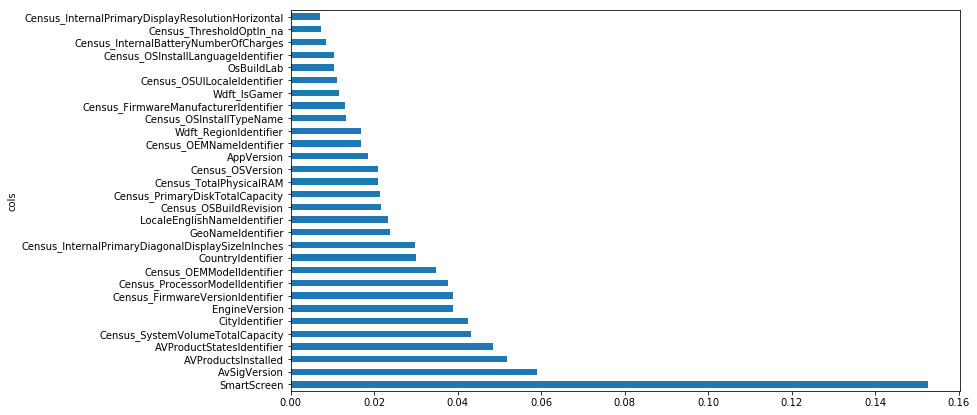

In [38]:
plot_fi(fi[:30]);

In [39]:
#Lets keep columns whose feature importance is greater than 0.1

In [26]:
to_keep = fi[fi.imp>0.01].cols; len(to_keep)

27

In [27]:
n_trn

80000

In [28]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [29]:
df_keep.columns

Index(['SmartScreen', 'AvSigVersion', 'AVProductStatesIdentifier',
       'AVProductsInstalled', 'EngineVersion',
       'Census_SystemVolumeTotalCapacity', 'CityIdentifier',
       'Census_FirmwareVersionIdentifier', 'Census_ProcessorModelIdentifier',
       'Census_OEMModelIdentifier',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches',
       'CountryIdentifier', 'Census_TotalPhysicalRAM', 'GeoNameIdentifier',
       'LocaleEnglishNameIdentifier', 'Census_PrimaryDiskTotalCapacity',
       'Census_OSVersion', 'Census_OSBuildRevision', 'AppVersion',
       'Wdft_RegionIdentifier', 'Census_OEMNameIdentifier',
       'Census_OSInstallTypeName', 'Census_FirmwareManufacturerIdentifier',
       'Wdft_IsGamer', 'Census_OSUILocaleIdentifier',
       'Census_OSInstallLanguageIdentifier', 'OsBuildLab'],
      dtype='object')

In [54]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=25, max_features=0.4, n_jobs=-1)
%time m.fit(X_train, y_train)


CPU times: user 1min 4s, sys: 47.9 ms, total: 1min 4s
Wall time: 16.6 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=25, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
print_score(m)

[0.7674457629660218, 0.6338986838317355]


### Thus scores are almost identical, by keeping only the relevant columns as it will make the final model simpler!


### Now , its a well known fact that random forest aren't very good in  extrapolating the results but serves as a very good starting point for building a baseline model!
### This weakness can be fixed by using graident boosting techniques, they work on  by improving the residual error, and can extrapolate much better than Random Forest We will use lgbm model in the other jupyter notebook alongside EDA Analysis! 
